In [25]:
import os
import cv2
import matplotlib.pyplot as plt
import importlib
import gel_tools
import numpy as np
from gel_tools.utils import Preprocessor
from gel_tools.lane_finder import LaneFinder
from gel_tools.band_measure import Band
from scipy.signal import find_peaks, find_peaks_cwt

%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Re-importing Packages

In [26]:
importlib.reload(gel_tools.lane_finder)
importlib.reload(gel_tools.utils)
from gel_tools.lane_finder import LaneFinder
from gel_tools.utils import Preprocessor

### Input Image View

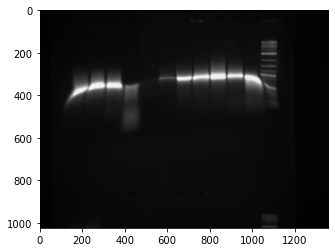

In [27]:
# Read chosen image from directory
%autoreload 2
img = cv2.imread("../samples/2_side_A.tif")
preprocessor = Preprocessor()
img_grey = preprocessor.apply_grayscale(img)
plt.imshow(img_grey, cmap='gray')
pass

### Finding Lanes

[[1.610e+02 1.840e+02 0.000e+00]
 [2.120e+02 3.050e+02 1.000e+00]
 [1.750e+02 2.270e+02 2.000e+00]
 [4.020e+02 4.580e+02 3.000e+00]
 [3.140e+02 3.890e+02 4.000e+00]
 [1.057e+03 1.099e+03 5.000e+00]
 [9.700e+02 1.046e+03 6.000e+00]
 [2.320e+02 3.020e+02 7.000e+00]
 [3.160e+02 3.780e+02 8.000e+00]
 [2.710e+02 2.980e+02 9.000e+00]
 [3.120e+02 3.860e+02 1.000e+01]
 [1.390e+02 3.000e+02 1.100e+01]
 [9.760e+02 1.032e+03 1.200e+01]
 [6.460e+02 7.100e+02 1.300e+01]
 [7.230e+02 7.930e+02 1.400e+01]
 [1.039e+03 1.106e+03 1.500e+01]
 [8.850e+02 9.520e+02 1.600e+01]
 [8.110e+02 8.640e+02 1.700e+01]
 [6.410e+02 1.038e+03 1.800e+01]
 [1.043e+03 1.111e+03 1.900e+01]]


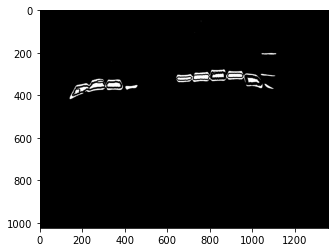

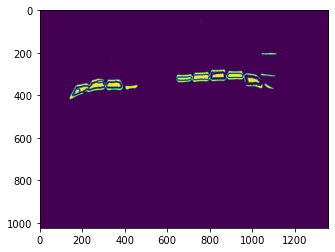

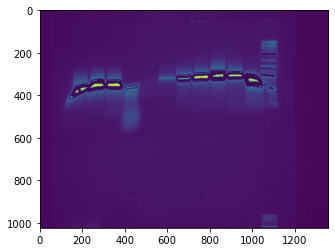

In [101]:
lane_finder = LaneFinder(img_grey)
lanes = lane_finder.find_lanes()
# Issues identified with inverted/faint images

In [102]:
lanes

{0: (139.0, 305.0),
 1: (312.0, 389.0),
 2: (402.0, 458.0),
 3: (641.0, 1038.0),
 4: (723.0, 793.0),
 5: (811.0, 864.0),
 6: (885.0, 952.0),
 7: (970.0, 1046.0),
 8: (1039.0, 1111.0)}

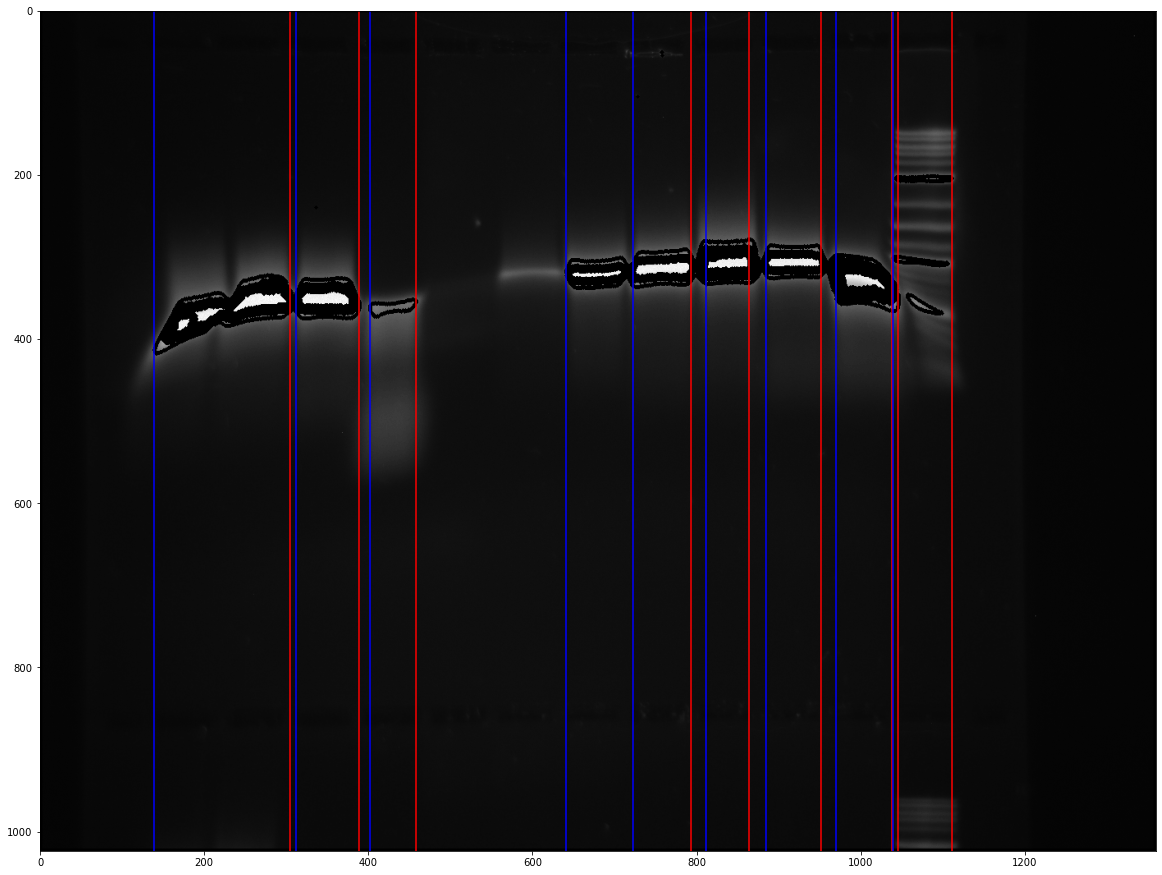

In [103]:
lane_finder.display_lanes(lanes)

In [59]:
# Next steps involve robustifying lane finder and detecting strength of different bands on the same lane.

### Band Testing

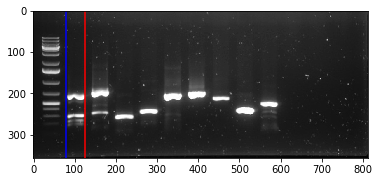

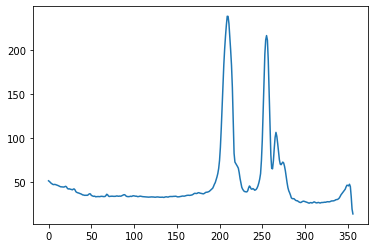

In [143]:
%reload_ext autoreload
img = cv2.imread("../samples/image3.jpg")
preprocessor = Preprocessor()
img_grey = preprocessor.apply_grayscale(img)
band_measure = Band()
band_measure.build_profile(img_grey, (80, 125))
profile = band_measure.raw_profile

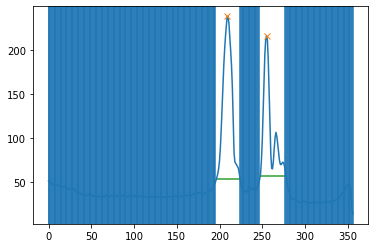

In [133]:
peaks, _ = find_peaks(profile,prominence=50)
peaksc = find_peaks_cwt(profile, np.arange(15,25))
plt.plot(profile)
peak_widths = signal.peak_widths(profile, peaks, rel_height=0.9)

plt.plot(peaks, profile[peaks], "x")

plt.hlines(*peak_widths[1:], color="C2")
for x in backgrnd:
    plt.axvline(x)
# plt.plot(peaksc, profile[peaksc], "x",color='b')

In [118]:
start=0
backgrnd = []
for peak in peak_widths[2:]:
    rpeak = peak.astype(int)
    backgrnd.extend(range(start,rpeak[0]))
    start = rpeak[1]
    print(rpeak)
backgrnd.extend(range(start,len(profile)))

[196 247]
[224 277]


## Background Removal

In [132]:
start = 0
backgrnd = []
for i in range(0,len(peak_widths[0])):
    s_peak = peak_widths[2][i].astype(int)
    backgrnd.extend(range(start,s_peak))
    start = peak_widths[3][i].astype(int)
    print(s_peak)
backgrnd.extend(range(start,len(profile)))

196
247


In [134]:
profilex = profile - np.mean(np.take(profile,backgrnd))

In [141]:
band_quant = []
for i in range(0,len(peak_widths[0])):
    s_peak = peak_widths[2][i].astype(int)
    f_peak = peak_widths[3][i].astype(int)
    band_quant.append(sum(profilex[s_peak:f_peak]))
    
band_percent = [band/sum(band_quant)  for band in band_quant]

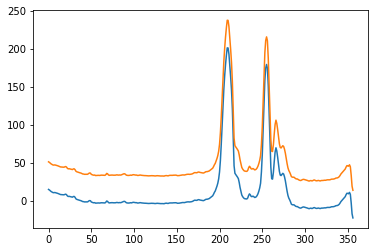

In [136]:
plt.plot(profilex)
plt.plot(profile)

In [142]:
band_percent

[0.5562598295151936, 0.44374017048480635]

In [131]:
len(peak_widths[0])

2

In [130]:
peak_widths

(array([28.02780623, 30.3380681 ]),
 array([53.58444444, 57.05777778]),
 array([196.15704225, 247.51501832]),
 array([224.18484848, 277.85308642]))

In [135]:
np.mean(np.take(profile,backgrnd))

36.29698996655518

In [119]:
peak_widths

(array([28.02780623, 30.3380681 ]),
 array([53.58444444, 57.05777778]),
 array([196.15704225, 247.51501832]),
 array([224.18484848, 277.85308642]))

## Class Implementation

[0.5562598295151936, 0.4437401704848065]

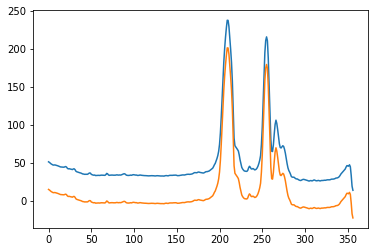

In [146]:
band_measure.find_peaks()
band_measure.remove_background()
band_measure.quantify_bands()
plt.plot(band_measure.raw_profile)
plt.plot(band_measure.profile)
band_measure.band_percentages

## Just Testing

In [62]:
import scipy.signal as signal

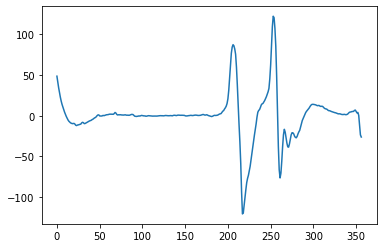

In [71]:
t = np.linspace(0, 1, 1000, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
sos = signal.butter(2, 15, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, profile)
plt.plot(filtered)

In [49]:
peaks

array([209, 255, 352])

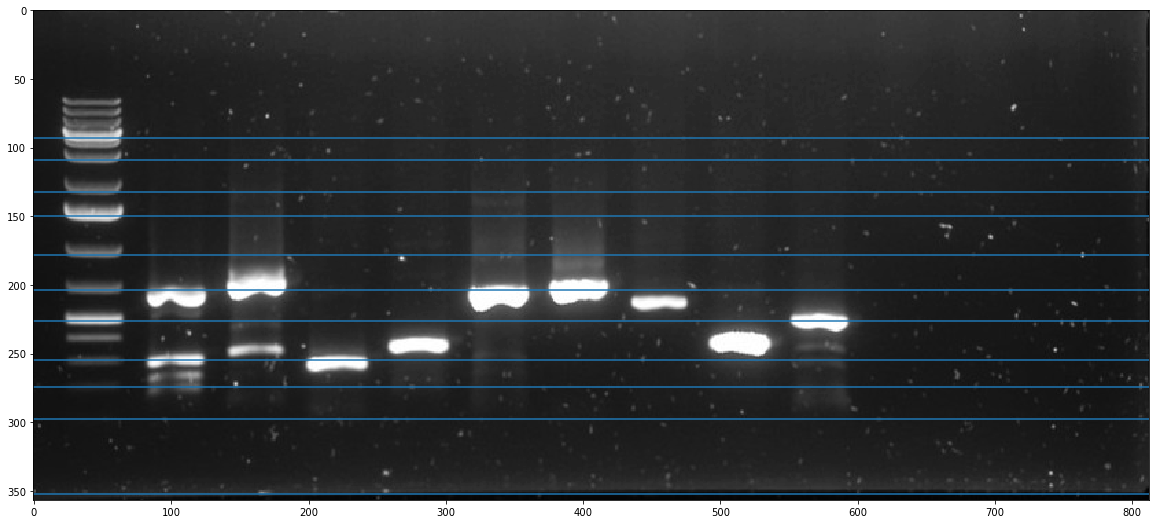

In [94]:
plt.figure(figsize=(20,20))
plt.imshow(img_grey, cmap='gray')
for peak in peaks:
    plt.axhline(peak)

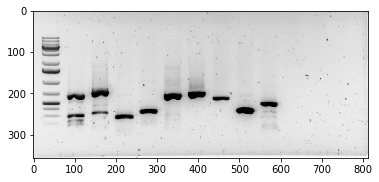

In [96]:
plt.imshow(1-img_grey,cmap='gray')

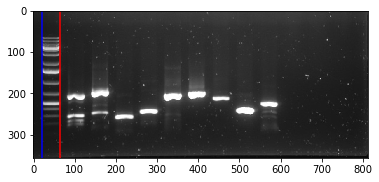

In [15]:
plt.imshow(img, cmap='gray')
plt.axvline(21, 0, color='b')
plt.axvline(65, 0, color='r')

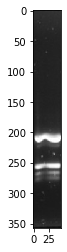

In [37]:
plt.imshow(img[:,80:125,:], cmap='gray')

In [38]:
cropped_im = img[:,80:125,:]

In [18]:
from skimage.measure import regionprops

In [39]:
props = regionprops(cropped_im)

In [24]:
props[0].centroid

(356.0, 42.5, 1.0)

In [40]:
# for prop in props:
#     print(prop.centroid)

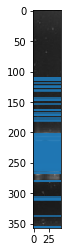

In [42]:
plt.imshow(cropped_im, cmap='gray')
for prop in props:
    plt.axhline(prop.centroid[0])

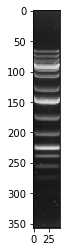

In [34]:
plt.imshow(cropped_im, cmap='gray')